# 突触模型

## 突触动力学

当我们建模好了神经元的发放以后，就需要把这些神经元连接起来了。突触对于神经元之间的沟通十分重要，是形成网络的重要组成部分。因此，我们需要对突触进行计算建模。

我们将在这一部分介绍如何用BrainPy实现突触的动力学。

### 化学突触

#### AMPA 突触

如图所示为神经元间信息传递的生物过程。突触前神经元释放的神经递质与突触后神经元上的受体结合，从而打开突触后神经元细胞膜上的离子通道，引起膜电位的变化。这里我们首先介绍经典的带有AMPA受体的突触，然后介绍如何用BrainPy实现它。

<img src="../figs/bio_syn.png" alt="bio_syn" style="zoom: 50%;" />

AMPA（a-氨基-3-羟基-5-甲基-4-异恶唑丙酸）型受体是一种离子型受体，它本身就是离子通道，所以当它被神经递质结合后，会立即打开离子通道，引起突触后神经元膜电位的变化。

一个经典的模型是用马尔可夫过程来建模离子通道的开关。这里$s$代表通道打开的概率，$1-s$代表离子通道关闭的概率，$\alpha$和$\beta$是转移概率（transition probability）。由于神经递质能让离子通道打开，所以从$1-s$到$s$的转移概率受神经递质浓度影响，我们将神经递质浓度表示为[T]，得到以下的马尔可夫过程。

<img src="../figs/markov.png" alt="markov" style="zoom: 25%;" />

把该过程用微分方程描述，得到以下式子。

$$
\frac {ds}{dt} = \alpha [T] (1-s) - \beta s
$$

其中，$\alpha [T]$ 表示从状态$(1-s)$到状态$(s)$的转移概率；$\beta$ 表示从s到(1-s)的转移概率。

下面我们来看看如何用BrainPy去实现这样一个模型。首先，我们要定义一个class，因为突触是连接两个神经元的，所以这个class继承自``bp.TwoEndConn``。

定义这个class，我们首先用``__init__``函数来初始化所需的参数和变量。首先，在突触中，我们需要``pre``和``post``来分别表示这个突触所连接的突触前神经元与突触后神经元。需要注意的是，``pre``和``post``都是向量，代表两群神经元，因此，我们还需要指定两群神经元具体链接情况的``conn``。在这里，我们可以从``conn``中获得连接矩阵``conn_mat``。

现在我们知道如何在BrainPy定义一个突触模型了，接下来就重点看一下如何实现AMPA突触。我们注意到，公式中有神经递质的浓度[T]，为了简化计算，[T]可以视为常数，并由``T_duration``控制它持续的时间。因此，我们简化的实现为，每当突触前神经元发放了，会释放神经递质，递质维持``T_duration``的时间长度后即清空。因此我们只需要判断，如果此时处于``T_duration``，则[T]=T，否则[T]=0。那么判断过程则需要用``t_last_pre_spike``这个变量来记录突触前神经元最近一次发放的时间。

完成初始化后，我们把微分方程的右边抄到``derivative``这个函数里，然后在``update``函数中更新[T]和$s$。

In [1]:
import brainpy as bp
bp.backend.set(backend='numpy', dt=0.1)

class AMPA(bp.TwoEndConn):
    target_backend = 'general'
    
    @staticmethod
    def derivative(s, t, TT, alpha, beta):
        ds = alpha * TT * (1 - s) - beta * s 
        return ds
    
    def __init__(self, pre, post, conn, alpha=0.98,
                 beta=0.18, T=0.5, T_duration=0.5,
                 **kwargs):
        # parameters
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration
        
        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variable
        self.s = bp.ops.zeros(self.size)
        self.t_last_pre_spike = -1e7 * bp.ops.ones(self.size)

        self.int_s = bp.odeint(f=self.derivative, method='exponential_euler')
        
        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)
        

      
    def update(self, _t):
        spike = bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.t_last_pre_spike = bp.ops.where(spike, _t, self.t_last_pre_spike)
        TT = ((_t - self.t_last_pre_spike) < self.T_duration) * self.T
        self.s = self.int_s(self.s, _t, TT, self.alpha, self.beta)

实现完后我们就可以画出$s$随时间变化的图。

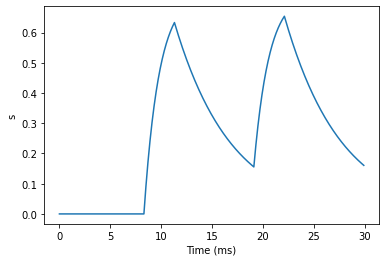

In [2]:
import brainmodels as bm

neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = AMPA(T_duration=3.,pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])

net = bp.Network(neu1, syn, neu2)
net.run(30., inputs=(neu1, 'input', 35.))
bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

由上图可以看到当突触前神经元发放后，$s$的值会先增加，然后decay。

#### 指数及Alpha突触模型

由于许多突触模型都有类似AMPA突触那样先上升后下降的动力学特征，有时候我们建模不需要具体对应到生物学上的突触，因此，有人提出了一些抽象的突触模型。这里，我们会介绍四种这类抽象模型在BrainPy上的实现。这些模型在``Brain-Models``中也有现成的提供。

##### (1) 双指数差（Differences of two exponentials）

我们首先来看双指数差（Differences of two exponentials）模型，它的公式如下：

$$
s = \frac {\tau_1 \tau_2}{\tau_1 - \tau_2} (\rm exp(-\frac{t - t_s}{\tau_1})
		- exp(-\frac{t - t_s}{\tau_2}))
$$


在BrainPy的实现中，我们采用以下微分方程形式：

$$
\frac {ds} {dt} = x
$$

$$
 \frac {dx}{dt} =- \frac{\tau_1+\tau_2}{\tau_1 \tau_2}x - \frac s {\tau_1 \tau_2}
$$

$$
\rm{if (fire), then} \ x \leftarrow x+ 1
$$



这里我们把判断当突触前神经元有发放时，$x$增加的逻辑写到``update``函数中。代码如下：

In [3]:
class Two_exponentials(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau1, tau2):
        dxdt = (-(tau1 + tau2) * x - s) / (tau1 * tau2)
        dsdt = x
        return dsdt, dxdt
    
    def __init__(self, pre, post, conn, tau1=1.0, tau2=3.0, **kwargs):
        # parameters
        self.tau1 = tau1
        self.tau2 = tau2

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)

        self.integral = bp.odeint(f=self.derivative, method='rk4')
        
        super(Two_exponentials, self).__init__(pre=pre, post=post, **kwargs)
    
    def update(self, _t):
        self.s, self.x = self.integral(self.s, self.x, _t, self.tau1, self.tau2)
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat

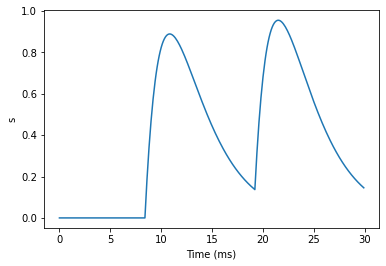

In [4]:
neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = Two_exponentials(tau1=2., pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])

net = bp.Network(neu1, syn, neu2)
net.run(30., inputs=(neu1, 'input', 35.))
bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

##### (2) Alpha突触

Alpha突触和上述模型类似，唯独在这里$\tau_1 = \tau_2$，因此公式更加简化了：

$$
\frac {ds} {dt} = x
$$

$$
 \frac {dx}{dt} =- \frac{2x}{\tau} - \frac s {\tau^2}
$$

$$
\rm{if (fire), then} \ x \leftarrow x+ 1
$$

代码实现也类似：

In [5]:
class Alpha(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau):
        dxdt = (-2 * tau * x - s) / (tau ** 2)
        dsdt = x
        return dsdt, dxdt
    
    def __init__(self, pre, post, conn, tau=3.0, **kwargs):
        # parameters
        self.tau = tau

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)

        self.integral = bp.odeint(f=self.derivative, method='rk4')
        
        super(Alpha, self).__init__(pre=pre, post=post, **kwargs)
    
    def update(self, _t):
        self.s, self.x = self.integral(self.s, self.x, _t, self.tau)
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat

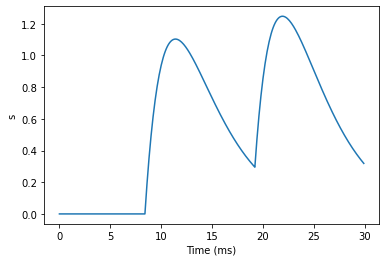

In [6]:
neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = Alpha(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])

net = bp.Network(neu1, syn, neu2)
net.run(30., inputs=(neu1, 'input', 35.))
bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

##### (3) 单指数衰减（Single exponential decay）

有时候在建模中可以忽略上升的过程，而只需要建模衰退（decay）的过程。这种模型称为单指数衰减（Single exponential decay）模型，其公式就更加简化了：

$$
\frac {ds}{dt}=-\frac s {\tau_{decay}}
$$

$$
\rm{if (fire), then} \ s \leftarrow s+1
$$

代码实现如下：

In [7]:
class Exponential(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = -s / tau
        return ds
    
    def __init__(self, pre, post, conn, tau=8.0, **kwargs):
        # parameters
        self.tau = tau

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        
        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
        
        super(Exponential, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau)
        self.s += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat

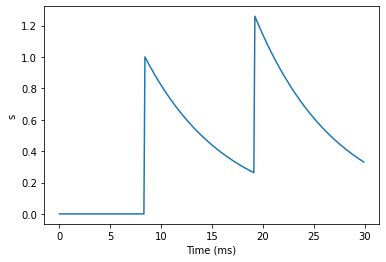

In [8]:
neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = Exponential(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])

net = bp.Network(neu1, syn, neu2)
net.run(30., inputs=(neu1, 'input', 35.))
bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

##### （4）电压跳变（Voltage jump）

建模上，有时候甚至连衰退的过程也可以忽略，这样的模型成为电压跳变（Voltage jump）模型，公式如下：

$$
\rm{if (fire), then} \ V \leftarrow V+1
$$

在实现上，连微分方程都不需要了，只需要在``update``函数中更新突触后膜的膜电位。但是，由于更新的是膜电位，因此要主要当突触后神经元为LIF等具有不应期的神经元时，不应期的时候不会改变膜电位。代码如下：

In [9]:
class Voltage_jump(bp.TwoEndConn):        
    target_backend = 'general'

    def __init__(self, pre, post, conn, post_refractory=False,  **kwargs):
        # parameters
        self.post_refractory = post_refractory

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        
        super(Voltage_jump, self).__init__(pre=pre, post=post, **kwargs)
    
    def update(self, _t):
        self.s = bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
             
        if self.post_refractory:
            refra_map = (1. - bp.ops.unsqueeze(self.post.refractory, 0)) * self.conn_mat
            self.post.V += bp.ops.sum(self.s * refra_map, axis=0)
        else:
            self.post.V += bp.ops.sum(self.s, axis=0)

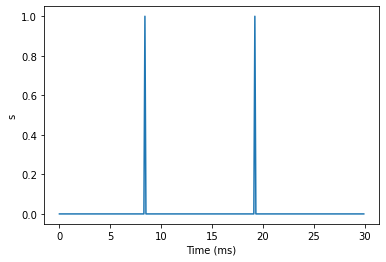

In [10]:
neu1 = bm.neurons.LIF(2, monitors=['V'])
neu2 = bm.neurons.LIF(3, monitors=['V'])
syn = Voltage_jump(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['s'])

net = bp.Network(neu1, syn, neu2)
net.run(30., inputs=(neu1, 'input', 35.))
bp.visualize.line_plot(net.ts, syn.mon.s, ylabel='s', show=True)

#### 基于电流的和基于电导的突触

前面我们已经建模了门控变量$s$。有两种不同的方法来建模从$s$到突触电流$I$（即突触后神经元的输入电流）的关系，分别为
**基于电流的（current-based）**
与**基于电导的（conductance-based）**。两者的主要区别在于突触电流是否受突触后神经元膜电位的影响。

基于电流的模型公式如下：

$$
I \propto s
$$

在代码实现上，我们通常会乘上一个权重$w$，我们可以通过调整权重的正负值来实现兴奋性和抑制性突触。

这里还通过使用BrainPy提供的``register_constant_delay``函数给变量``I_ syn``加上延迟时间来实现突触的延迟。

In [11]:
def __init__(self, pre, post, conn, **kwargs):
    # ...
    self.s = bp.ops.zeros(self.size)
    self.w = bp.ops.ones(self.size) * .2
    self.out = self.register_constant_delay('out', size=self.size, delay_time=delay)

def update(self, _t):
    for i in nb.prange(self.size):
        # ... 
        self.out.push(i, self.w[i] * self.s[i])
        self.post.input[post_id] += self.out.pull(i) 

在基于电导的模型中，电导为$g=\bar{g}s$。因此，根据欧姆定律得公式如下：

$$
I=\bar{g}s(V-E)
$$

这里$E$是一个反转电位（reverse potential），它可以决定$I$的方向是抑制还是兴奋。例如，当静息电位约为-65时，减去比它更低的$E$，例如-75，将变为正，从而改变公式中电流的方向并产生抑制电流。兴奋性突触的$E$一般为比较高的值，如0。

代码实现上，可以把延迟时间应用到变量``g``上。

In [12]:
def __init__(self, pre, post, conn, g_max, E, **kwargs):
    self.g_max = g_max
    self.E = E
    # ...
    self.s = bp.ops.zeros(self.size)
    self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

def update(self, _t):
    for i in nb.prange(self.size):
        # ...
        self.g.push(i, self.g_max * self.s[i])
        self.post.input[post_id] -= self.g.pull(i) * (self.post.V[post_id] - self.E)

### 电突触（缝隙连接 Gap junction）

除了前面介绍的化学突触以外，电突触在我们神经系统中也很常见。

<img src="../figs/bio_gap.png" alt="bio_gap"  />

如上图，两个神经元通过连接通道 (junction channels) 相连，可以直接导电。因此，可以看作是两个神经元由一个常数电阻连起来，如下图所示。

<img src="../figs/gap_model.jpg" alt="gap_model" style="zoom: 67%;" />

根据欧姆定律可得以下公式。

$$
I_{1} = w (V_{0} - V_{1})
$$

这里电导表示为$w$，它表示连接的权重。

在BrainPy的实现中，只需要在``update``函数里更新即可。

In [13]:
class Gap_junction(bp.TwoEndConn):
    target_backend = 'general'

    def __init__(self, pre, post, conn, delay=0., k_spikelet=0.1, post_refractory=False,  **kwargs):
        self.delay = delay
        self.k_spikelet = k_spikelet
        self.post_refractory = post_refractory

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.w = bp.ops.ones(self.size)
        self.spikelet = self.register_constant_delay('spikelet', size=self.size, delay_time=delay)

        super(Gap_junction, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        v_post = bp.ops.vstack((self.post.V,) * self.size[0])
        v_pre = bp.ops.vstack((self.pre.V,) * self.size[1]).T

        I_syn = self.w * (v_pre - v_post) * self.conn_mat
        self.post.input += bp.ops.sum(I_syn, axis=0)

        self.spikelet.push(self.w * self.k_spikelet * bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat)

        if self.post_refractory:
            self.post.V += bp.ops.sum(self.spikelet.pull(), axis=0) * (1. - self.post.refractory)
        else:
            self.post.V += bp.ops.sum(self.spikelet.pull(), axis=0)

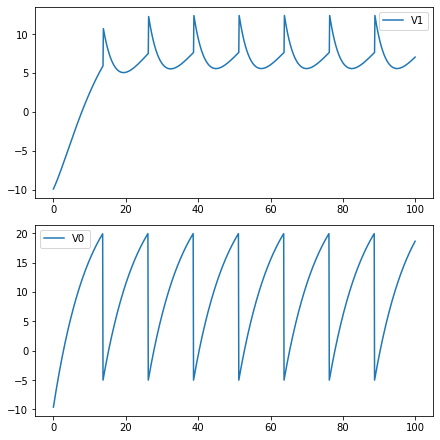

In [14]:
import matplotlib.pyplot as plt
import numpy as np

neu0 = bm.neurons.LIF(2, monitors=['V'], t_refractory=0)
neu0.V = np.ones(neu0.V.shape) * -10.
neu1 = bm.neurons.LIF(3, monitors=['V'], t_refractory=0)
neu1.V = np.ones(neu1.V.shape) * -10.
syn = Gap_junction(pre=neu0, post=neu1, conn=bp.connect.All2All(),
                    k_spikelet=5.)
syn.w = np.ones(syn.w.shape) * .5

net = bp.Network(neu0, neu1, syn)
net.run(100., inputs=(neu0, 'input', 30.))

fig, gs = bp.visualize.get_figure(row_num=2, col_num=1, )

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, neu0.mon.V[:, 0], label='V0')
plt.legend()

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V[:, 0], label='V1')
plt.legend()
plt.show()

## 突触可塑性

我们刚刚讨论了突触动力学，但还没有涉及到突触可塑性。接下来就来看看如何使用BrainPy实现突触可塑性。

可塑性主要区分短时程可塑性与长时程可塑性。我们将首先介绍突触短时程可塑性（STP），然后介绍几种不同的突触长时程可塑性模型。

### 突触短时程可塑性（STP）

我们首先看实验的结果，图为突触前神经元发放时突触后神经元膜电位的变化。我们可以看到，当突触前神经元以短时间间隔持续发放的时候，突触后神经元的反应会越来越弱，呈现出短时程抑制 (short term depression)。但是很快就恢复了，所以这个可塑性是短期的。

<img src="../figs/stp.png">

模型的公式如下。在这里，短时程可塑性主要由$u$和$x$两个变量来描述。其中，$u$表示神经递质释放的概率，初始值为0，并随着突触前神经元的每次发放而增加，贡献短时程易化（STF）；而$x$代表神经递质的剩余量，初始值为1，每次突触前神经元发放都会用掉一些，这意味着它会减少，从而贡献短时程抑制（STD）。因此易化和抑制两个方向是同时发生的。$\tau_f$和$\tau_d$分别控制$u$和$x$的恢复速度，两者关系决定了可塑性的哪个方向起主导作用。

$$
\frac {dI} {dt} = - \frac I {\tau}
$$

$$
\frac {du} {dt} = - \frac u {\tau_f} 
$$

$$
\frac {dx} {dt} =  \frac {1-x} {\tau_d} 
$$

$$
\rm{if (pre \ fire), then}
\begin{cases} 
u^+ = u^- + U(1-u^-) \\ 
I^+ = I^- + Au^+x^- \\
x^+ = x^- - u^+x^- 
\end{cases}
$$

用BrainPy实现的代码如下：

In [15]:
class STP(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, u, x, t, tau, tau_d, tau_f):
        dsdt = -s / tau
        dudt = - u / tau_f
        dxdt = (1 - x) / tau_d
        return dsdt, dudt, dxdt
    
    def __init__(self, pre, post, conn, delay=0., U=0.15, tau_f=1500., tau_d=200., tau=8.,  **kwargs):
        # parameters
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.tau = tau
        self.U = U
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.ones(self.size)
        self.u = bp.ops.zeros(self.size)
        self.w = bp.ops.ones(self.size)
        self.I_syn = self.register_constant_delay('I_syn', size=self.size, delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
        
        super(STP, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        self.s, u, x = self.integral(self.s, self.u, self.x, _t, self.tau, self.tau_d, self.tau_f)
        
        pre_spike_map = bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        u += self.U * (1-self.u) * pre_spike_map
        self.s += self.w * u * self.x * pre_spike_map
        x -= u * self.x * pre_spike_map
        
        self.u = u
        self.x = x

        self.I_syn.push(self.s)
        self.post.input += bp.ops.sum(self.I_syn.pull(), axis=0)

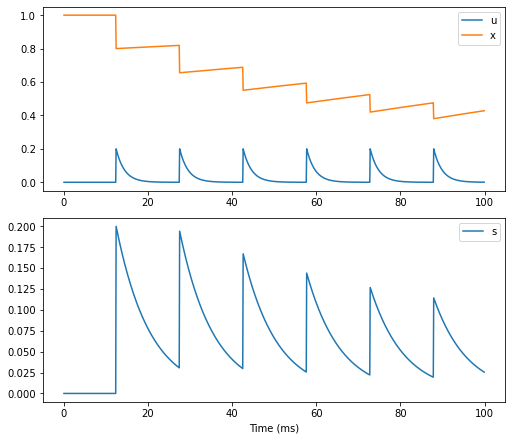

In [16]:
neu1 = bm.neurons.LIF(1, monitors=['V'])
neu2 = bm.neurons.LIF(1, monitors=['V'])

# STD
syn = STP(U=0.2, tau_d=150., tau_f=2., pre=neu1, post=neu2, 
          conn=bp.connect.All2All(), monitors=['s', 'u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(100., inputs=(neu1, 'input', 28.))

# plot
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

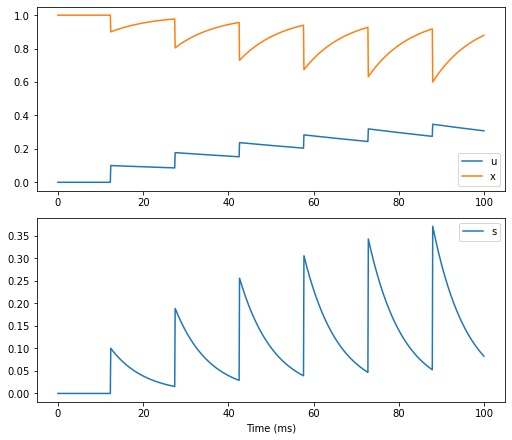

In [17]:
neu1 = bm.neurons.LIF(1, monitors=['V'])
neu2 = bm.neurons.LIF(1, monitors=['V'])

# STF
syn = STP(U=0.1, tau_d=10, tau_f=100., pre=neu1, post=neu2, 
          conn=bp.connect.All2All(), monitors=['s', 'u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(100., inputs=(neu1, 'input', 28.))

# plot
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

这些图显示，当我们设置参数$\tau_d>\tau_f$、$x$每用掉一些后恢复非常缓慢，$u$每次上升后非常快衰减，因此，transmitter不够用了，不足以打开受体，表现出STD为主；
相反，当$\tau_f > \tau_d$，$x$每次用到后很快又补充回去了，总是有足够的transmitter可用。同时，$u$的衰减非常缓慢，因此释放transmitter的概率越来越高，表现出STF为主。

### 突触长时程可塑性

#### 脉冲时间依赖可塑性（STDP）

首先我们看实验上画的图，x轴是突触前神经元和突触后神经元发放的时间差，零的左侧代表突触前神经元的发放比突触后神经元的更早，由图片可以看出表现为长时程增强 (long term potentiation; LTP）；而零的右侧代表突触后神经元比突触前神经元更先发放，呈现表现为长时程抑制 (long term depression; LTD）。

<img src="../figs/stdp.png">


模型公式如下，其中$A_{source}$和$A_{target}$两个变量分别控制LTD和LTP。当突触前神经元先于突触后神经元发放时，在突触后神经元发放之前，$A_t$一直为0，所以$w$暂时不会有变化，只是$A_s$持续增加；直到突触后神经元发放时，$w$增加$A_s - A_t$，所以表现为长时程增强（LTP）。反之亦然。

$$
\frac {dA_s} {dt} = - \frac {A_s} {\tau_s} 
$$

$$
\frac {dA_t} {dt} = - \frac {A_t} {\tau_t} 
$$

$$
\rm{if (pre \ fire), then}
\begin{cases} 
s \leftarrow s + w \\
A_s \leftarrow A_s + \Delta A_s \\ 
w \leftarrow w - A_t 
\end{cases}
$$

$$
\rm{if (post \ fire), then}
\begin{cases} 
A_t \leftarrow A_t + \Delta A_t \\ 
w \leftarrow w + A_s 
\end{cases}
$$

现在让我们看看如何使用BrainPy来实现这个模型。$s$会在突触前神经元出现脉冲时增加，这与前面介绍的突触模型的动力学一致，这里我们通常使用单指数衰减 (single exponential decay)模型来实现$s$的动力学。

In [18]:
class STDP(bp.TwoEndConn):
    target_backend = 'general'
    
    @staticmethod
    def derivative(s, A_s, A_t, t, tau, tau_s, tau_t):
        dsdt = -s / tau
        dAsdt = - A_s / tau_s
        dAtdt = - A_t / tau_t
        return dsdt, dAsdt, dAtdt
    
    def __init__(self, pre, post, conn, delay=0., 
                delta_A_s=0.5, delta_A_t=0.5, w_min=0., w_max=20., 
                tau_s=10., tau_t=10., tau=10., **kwargs):
        # parameters
        self.tau_s = tau_s
        self.tau_t = tau_t
        self.tau = tau
        self.delta_A_s = delta_A_s
        self.delta_A_t = delta_A_t
        self.w_min = w_min
        self.w_max = w_max
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.A_s = bp.ops.zeros(self.size)
        self.A_t = bp.ops.zeros(self.size)
        self.w = bp.ops.ones(self.size) * 1.
        self.I_syn = self.register_constant_delay('I_syn', size=self.size, delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
        
        super(STDP, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        s, A_s, A_t = self.integral(self.s, self.A_s, self.A_t, 
                                    _t, self.tau, self.tau_s, self.tau_t)
        w = self.w

        pre_spike_map = bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        s += w * pre_spike_map
        A_s += self.delta_A_s * pre_spike_map
        w -= A_t * pre_spike_map
        
        post_spike_map = bp.ops.unsqueeze(self.post.spike, 0) * self.conn_mat
        A_t += self.delta_A_t * post_spike_map
        w += A_s * post_spike_map
        
        self.A_s = A_s
        self.A_t = A_t
        self.w = bp.ops.clip(w, self.w_min, self.w_max)
        self.s = s

        self.I_syn.push(self.s)
        self.post.input += bp.ops.sum(self.I_syn.pull(), axis=0)

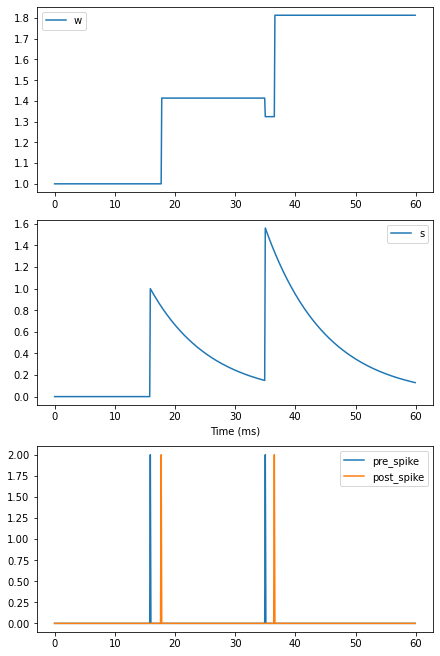

In [19]:
pre = bm.neurons.LIF(1, monitors=['spike'])
post = bm.neurons.LIF(1, monitors=['spike'])

# pre before post
duration = 60.
(I_pre, _) = bp.inputs.constant_current([(0, 5), (30, 15), 
                                         (0, 5), (30, 15), 
                                         (0, duration-40)])
(I_post, _) = bp.inputs.constant_current([(0, 7), (30, 15), 
                                          (0, 5), (30, 15), 
                                          (0, duration-7-35)])

syn = STDP(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s', 'A_s', 'A_t', 'w'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=[(pre, 'input', I_pre), (post, 'input', I_post)])

# plot
fig, gs = bp.visualize.get_figure(3, 1)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.w[:, 0], label='w')
plt.legend()

fig.add_subplot(gs[2, 0])
plt.plot(net.ts, 2*pre.mon.spike[:, 0], label='pre_spike')
plt.plot(net.ts, 2*post.mon.spike[:, 0], label='post_spike')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

结果正如我们所预期的，当突触前神经元在突触后神经元之前发放时，$w$增加，呈现LTP。

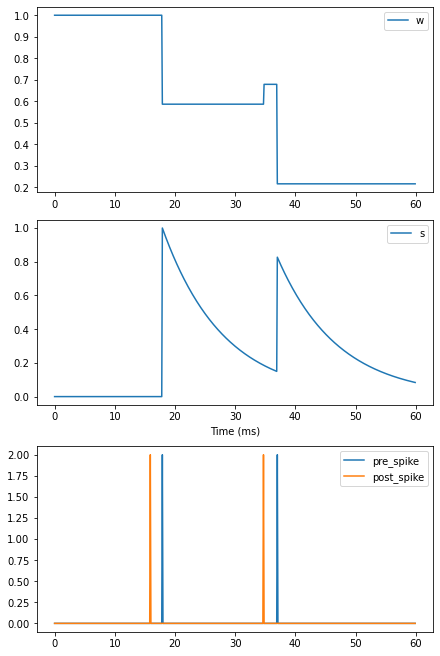

In [20]:
pre = bm.neurons.LIF(1, monitors=['spike'])
post = bm.neurons.LIF(1, monitors=['spike'])

# post before pre
duration = 60.
(I_post, _) = bp.inputs.constant_current([(0, 5), (30, 15), 
                                         (0, 5), (30, 15), 
                                         (0, duration-40)])
(I_pre, _) = bp.inputs.constant_current([(0, 7), (30, 15), 
                                          (0, 5), (30, 15), 
                                          (0, duration-7-35)])

syn = STDP(pre=pre, post=post, conn=bp.connect.All2All(), monitors=['s', 'A_s', 'A_t', 'w'])
net = bp.Network(pre, syn, post)
net.run(duration, inputs=[(pre, 'input', I_pre), (post, 'input', I_post)])

# plot
fig, gs = bp.visualize.get_figure(3, 1)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.w[:, 0], label='w')
plt.legend()

fig.add_subplot(gs[2, 0])
plt.plot(net.ts, 2*pre.mon.spike[:, 0], label='pre_spike')
plt.plot(net.ts, 2*post.mon.spike[:, 0], label='post_spike')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

如我们所料，当突触后神经元先于突触前神经元发放时，$w$减少，呈现LTD。

#### Oja法则

接下来我们看基于赫布学习律（Hebbian learning）的发放率模型 (rate model)。

赫布学习律认为相互连接的两个神经元在经历同步的放电活动后，它们之间的突触连接就会得到增强。而这个同步不需要在意两个神经元前后发放的次序，因此可以忽略具体的发放时间，简化为发放率模型。我们首先看赫布学习律的一般形式，对于如图所示的$j$到$i$的连接，用$v_j，v_i$分别表示前神经元组和后神经元组的发放率 (firing rate)，根据赫布学习律的局部性(locality)特性，$w_{ij}$的变化受$w$本身、以及$v_j, v_i$的影响，可得以下微分方程。

$$
\frac d {dt} w_{ij} = F(w_{ij}; v_{i},v_j)
$$

把上式右边经过泰勒展开得到以下式子。

$$
\frac d {dt} w_{ij} = c_{00} w_{ij} + c_{10} w_{ij} v_j + c_{01} w_{ij} v_i + c_{20} w_{ij} v_j ^2 + c_{02} w_{ij} v_i ^2 + c_{11} w_{ij} v_i v_j + O(v^3)
$$

第6项包含$v_i v_j$，$c_{11}$非0才满足赫布学习律的同步发放。例如**Oja法则**的公式如下，可以看出对应于上式第5、6项。

$$
\frac d {dt} w_{ij} = \gamma [v_i v_j - w_{ij} v_i ^2 ]
$$

下面我们用BrainPy来实现Oja法则。

In [21]:
class Oja(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(w, t, gamma, r_pre, r_post):
        dwdt = gamma * (r_post * r_pre - r_post * r_post * w)
        return dwdt

    def __init__(self, pre, post, conn, delay=0.,
                 gamma=0.005, w_max=1., w_min=0.,
                 **kwargs):
        # params
        self.gamma = gamma
        self.w_max = w_max
        self.w_min = w_min
        # no delay in firing rate models

        # conns
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.w = bp.ops.ones(self.size) * 0.05

        self.integral = bp.odeint(f=self.derivative)
        super(Oja, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        w = self.conn_mat * self.w
        self.post.r = bp.ops.sum(w.T * self.pre.r, axis=1)
        
        # resize to matrix
        dim = self.size
        r_post = bp.ops.vstack((self.post.r,) * dim[0])
        r_pre = bp.ops.vstack((self.pre.r,) * dim[1]).T
        
        self.w = self.integral(w, _t, self.gamma, r_pre, r_post)

我们打算实现如图所示的连接，紫色同时接受蓝色和红色两群神经元的输入。给后神经元的input和红色是完全一致的，而蓝色一开始一致，后来不一致了。

<img src="../figs/conn.png" alt="conn" />

由于Oja是一个速率模型，我们需要一个基于速率的神经元模型来观察两组神经元的学习规则。

In [22]:
class neu(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def integral(r, t, I, tau):
        dr = -r / tau + I
        return dr

    def __init__(self, size, tau=10., **kwargs):
        self.tau = tau

        self.r = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)

        self.g = bp.odeint(self.integral)

        super(neu, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.r = self.g(self.r, _t, self.input, self.tau)
        self.input[:] = 0

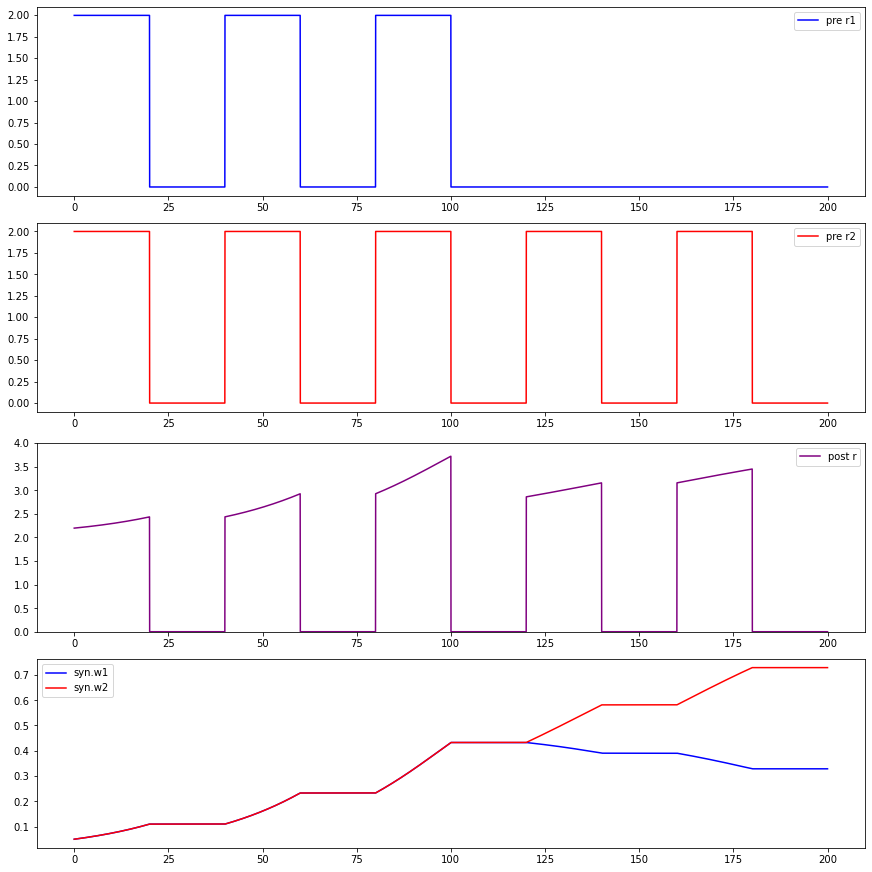

In [23]:
# set params
neu_pre_num = 2
neu_post_num = 2
dt = 0.02
bp.backend.set('numpy', dt=dt)

# build network
neu_pre = neu(neu_pre_num, monitors=['r'])
neu_post = neu(neu_post_num, monitors=['r'])

syn = Oja(pre=neu_pre, post=neu_post,
          conn=bp.connect.All2All(), monitors=['w'])

net = bp.Network(neu_pre, syn, neu_post)

# create input
current_mat_in = []
current_mat_out = []
current1, _ = bp.inputs.constant_current(
    [(2., 20.), (0., 20.)] * 3 + [(0., 20.), (0., 20.)] * 2)
current2, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 5)
current3, _ = bp.inputs.constant_current([(2., 20.), (0., 20.)] * 5)
current_mat_in = np.vstack((current1, current2))
current_mat_out = current3
current_mat_out = np.vstack((current_mat_out, current3))

# simulate network
net.run(duration=200.,
        inputs=[(neu_pre, 'r', current_mat_in.T, '='),
                (neu_post, 'r', current_mat_out.T)])

# paint
fig, gs = bp.visualize.get_figure(4, 1, 3, 12)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu_pre.mon.r[:, 0], 'b', label='pre r1')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, neu_pre.mon.r[:, 1], 'r', label='pre r2')
plt.legend()

fig.add_subplot(gs[2, 0])
plt.plot(net.ts, neu_post.mon.r[:, 0], color='purple', label='post r')
plt.ylim([0, 4])
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, syn.mon.w[:, 0, 0], 'b', label='syn.w1')
plt.plot(net.ts, syn.mon.w[:, 1, 0], 'r', label='syn.w2')
plt.legend()
plt.show()

从结果可以看到，一开始两群神经元同时给input时，他们的weights都上升，post的反应越来越强，显示出LTP。100ms后，group1不再一起发放，只有group2给input，就只有group2的weights增加。结果符合Hebbian learning的fire together，wire together。

#### BCM法则

BCM法则的公式如下：

$$
\frac d{dt} w_{ij} =  \eta v_i(v_i - v_\theta) v_j
$$

公式右边画出来如下图所示，当发放频率高于阈值时呈现LTP，低于阈值时则为LTD。因此，通过调整阈值可以实现选择性。

<img src="../figs/bcm.png">



这里我们使用和Oja法则相同的连接方式，只是两群神经元为交替发放。其中，蓝色总比红色发放更强一些。动态调整阈值为$v_i$的时间平均，即 $v_\theta = f(v_i)$。BrainPy实现的代码如下，在``update``函数中更新阈值。

In [24]:
class BCM(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(w, t, lr, r_pre, r_post, r_th):
        dwdt = lr * r_post * (r_post - r_th) * r_pre
        return dwdt

    def __init__(self, pre, post, conn, lr=0.005, w_max=2., w_min=0., **kwargs):
        # parameters
        self.lr = lr
        self.w_max = w_max
        self.w_min = w_min
        self.dt = bp.backend._dt

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.w = bp.ops.ones(self.size)
        self.sum_post_r = bp.ops.zeros(post.size[0])

        self.int_w = bp.odeint(f=self.derivative, method='rk4')

        super(BCM, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        # update threshold
        self.sum_post_r += self.post.r
        r_th = self.sum_post_r / (_t / self.dt + 1)

        # resize to matrix
        w = self.w * self.conn_mat
        dim = self.size
        r_th = bp.ops.vstack((r_th,) * dim[0])
        r_post = bp.ops.vstack((self.post.r,) * dim[0])
        r_pre = bp.ops.vstack((self.pre.r,) * dim[1]).T

        # update w
        w = self.int_w(w, _t, self.lr, r_pre, r_post, r_th)
        self.w = bp.ops.clip(w, self.w_min, self.w_max)

        # output
        self.post.r = bp.ops.sum(w.T * self.pre.r, axis=1)

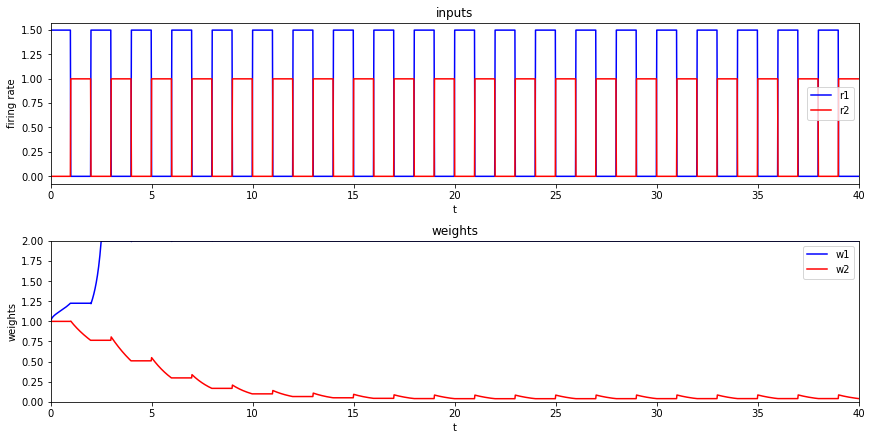

In [25]:
w_max = 2.
n_post = 1
n_pre = 20

# group selection
group1, duration = bp.inputs.constant_current(([1.5, 1], [0, 1]) * 20)
group2, duration = bp.inputs.constant_current(([0, 1], [1., 1]) * 20)

group1 = bp.ops.vstack((
                    (group1,)*10))

group2 = bp.ops.vstack((
                    (group2,)*10
                    ))
input_r = bp.ops.vstack((group1, group2))

pre = neu(n_pre, monitors=['r'])
post = neu(n_post, monitors=['r'])
bcm = BCM(pre=pre, post=post,conn=bp.connect.All2All(),
          monitors=['w'])

net = bp.Network(pre, bcm, post)
net.run(duration, inputs=(pre, 'r', input_r.T, "="))

w1 = bp.ops.mean(bcm.mon.w[:, :10, 0], 1)
w2 = bp.ops.mean(bcm.mon.w[:, 10:, 0], 1)

r1 = bp.ops.mean(pre.mon.r[:, :10], 1)
r2 = bp.ops.mean(pre.mon.r[:, 10:], 1)
post_r = bp.ops.mean(post.mon.r[:, :], 1)

fig, gs = bp.visualize.get_figure(2, 1, 3, 12)
fig.add_subplot(gs[1, 0], xlim=(0, duration), ylim=(0, w_max))
plt.plot(net.ts, w1, 'b', label='w1')
plt.plot(net.ts, w2, 'r', label='w2')
plt.title("weights")
plt.ylabel("weights")
plt.xlabel("t")
plt.legend()

fig.add_subplot(gs[0, 0], xlim=(0, duration))
plt.plot(net.ts, r1, 'b', label='r1')
plt.plot(net.ts, r2, 'r', label='r2')
plt.title("inputs")
plt.ylabel("firing rate")
plt.xlabel("t")
plt.legend()

plt.show()

结果发现，对input较强的group 1是LTP，而对input较弱的group 2是LTD，最终选择了group 1。

# 网络模型

## 脉冲网络 Spiking networks

## 发放率网络 Firing rate networks

### 决择模型

除了脉冲模型以外，BrainPy同样也可以实现发放率模型（Firing rate models）。我们首先来看看前述抉择模型的简化版本的实现。该模型由研究者（Wong & Wang, 2006）通过平均场方法（mean-field approach）等一系列手段简化得出，最终只剩下两个变量，$S_1$和$S_2$，分别表示两群神经元的状态，同时也分别对应着两个选项。

<img src="../figs/decision.png">

公式如下：
$$
\frac{dS_1} {dt} = -\frac {S_1} \tau + (1-S_1) \gamma r_1
$$

$$
\frac{dS_2} {dt} = -\frac {S_2} \tau + (1-S_2) \gamma r_2
$$

其中 $r_1$ 和 $r_2$ 分别为两群神经元的发放率，由输入-输出函数（input-output function）给出，为：

$$
r_i = f(I_{syn, i}) 
$$

$$
f(I)= \frac {aI-b} {1- \exp [-d(aI-b)]}
$$

$I_{syn, i}$ 的公式由模型结构给出，为自身的循环（recurrent）连接减去对方传来的抑制电流，并加上背景电流及外界输入，可得：

$$
I_{syn, 1} = J_{11} S_1 - J_{12} S_2 + I_0 + I_1
$$

$$
I_{syn, 2} = J_{22} S_2 - J_{21} S_1 + I_0 + I_2
$$

而外界输入 $I_1, I_2$ 则由总输入的强度 $\mu_0$ 及一致性（coherence） $c'$ 决定。一致性越高，则越明确$S_1$是正确答案，而一致性越低则表示越随机。公式如下：

$$
I_1 = J_{\rm A, ext} \mu_0 (1+\frac {c'}{100\%})
$$

$$
I_2 = J_{\rm A, ext} \mu_0 (1-\frac {c'}{100\%})
$$


代码实现如下，我们可以创建一个神经元群的类（``bp.NeuGroup``），并用$S_1$及$S_2$分别储存这群神经元的两个状态。该模型的动力学部分可以由一个``derivative``函数实现，以便进行动力学分析。

In [26]:
class Decision(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(s1, s2, t, I, coh, JAext, J_rec, J_inh, I_0, b, d, a, tau_s, gamma):
        I1 = JAext * I * (1. + coh)
        I2 = JAext * I * (1. - coh)

        I_syn1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        r1 = (a * I_syn1 - b) / (1. - bp.ops.exp(-d * (a * I_syn1 - b)))
        ds1dt = - s1 / tau_s + (1. - s1) * gamma * r1

        I_syn2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        r2 = (a * I_syn2 - b) / (1. - bp.ops.exp(-d * (a * I_syn2 - b)))
        ds2dt = - s2 / tau_s + (1. - s2) * gamma * r2

        return ds1dt, ds2dt

    def __init__(self, size, coh, tau_s=.06, gamma=0.641,
                 J_rec=.3725, J_inh=.1137,
                 I_0=.3297, JAext=.00117,
                 a=270., b=108., d=0.154,
                 **kwargs):
        # parameters
        self.coh = coh
        self.tau_s = tau_s
        self.gamma = gamma
        self.J_rec = J_rec
        self.J_inh = J_inh
        self.I0 = I_0
        self.JAext = JAext
        self.a = a
        self.b = b
        self.d = d

        # variables
        self.s1 = bp.ops.ones(size) * .06
        self.s2 = bp.ops.ones(size) * .06
        self.input = bp.ops.zeros(size)

        self.integral = bp.odeint(f=self.derivative, method='rk4', dt=0.01)

        super(Decision, self).__init__(size=size, **kwargs)

    def update(self, _t):
        for i in prange(self.size):
            self.s1[i], self.s2[i] = self.integral(self.s1[i], self.s2[i], _t,
                                                   self.input[i], self.coh, self.JAext, self.J_rec,
                                                   self.J_inh, self.I0, self.b, self.d,
                                                   self.a, self.tau_s, self.gamma)
            self.input[i] = 0.

相平面分析代码如下。我们首先看没有外界输入的情况，此时$\mu_0 = 0$。

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.06176109215560733, s1=0.061761097890810475 is a stable node.
Fixed point #2 at s2=0.029354239100062428, s1=0.18815448592736211 is a saddle node.
Fixed point #3 at s2=0.0042468423702408655, s1=0.6303045696241589 is a stable node.
Fixed point #4 at s2=0.6303045696241589, s1=0.004246842370235128 is a stable node.
Fixed point #5 at s2=0.18815439944520335, s1=0.029354240536530615 is a saddle node.
plot vector field ...


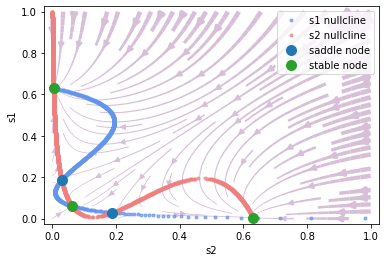

In [27]:
from collections import OrderedDict

pars = dict(tau_s=.06, gamma=0.641,
            J_rec=.3725, J_inh=.1137,
            I_0=.3297, JAext=.00117,
            b=108., d=0.154, a=270.)

pars['I'] = 0.
pars['coh'] = 0.

decision = Decision(1, coh=pars['coh'])

phase = bp.analysis.PhasePlane(decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

由此可见，用BrainPy进行动力学分析是非常方便的。向量场和不动点 (fixed point)表示了不同初始值下最终会落在哪个选项。

这里，x轴是$S_2$，代表选项2，y轴是$S_1$，代表选项1。可以看到，左上的不动点 表示选项1，右下的不动点表示选项2，左下的不动点表示没有选择。

现在让我们看看当我们把外部输入强度固定为30时，在不同一致性（coherence）下的相平面。

coherence = 0%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.6993504413889349, s1=0.011622049526766405 is a stable node.
Fixed point #2 at s2=0.49867489858358865, s1=0.49867489858358865 is a saddle node.
Fixed point #3 at s2=0.011622051540013889, s1=0.6993504355529329 is a stable node.
plot vector field ...


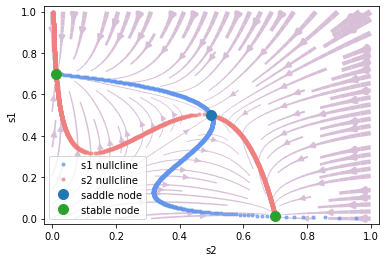

coherence = 51.2%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.5673124813731691, s1=0.2864701069327971 is a saddle node.
Fixed point #2 at s2=0.6655747347157656, s1=0.027835279565912054 is a stable node.
Fixed point #3 at s2=0.005397687847426814, s1=0.7231453520305031 is a stable node.
plot vector field ...


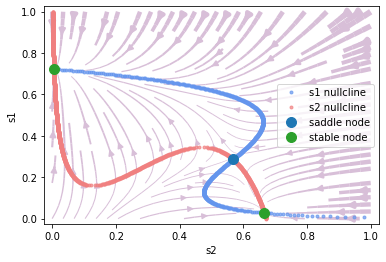

coherence = 100%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.0026865954387078755, s1=0.7410985604497689 is a stable node.
plot vector field ...


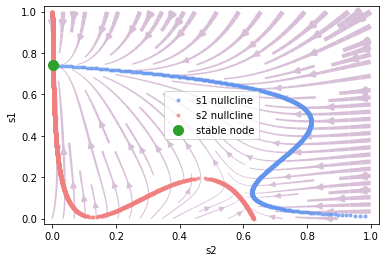

In [28]:
# coherence = 0%
pars['I'] = 30.
pars['coh'] = 0.

decision = Decision(1, coh=pars['coh'])

phase = bp.analysis.PhasePlane(decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

print("coherence = 0%")
phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

# coherence = 51.2%
pars['coh'] = 0.512

decision = Decision(1, coh=pars['coh'])

phase = bp.analysis.PhasePlane(decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

print("coherence = 51.2%")
phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)


# coherence = 100%
pars['coh'] = 1.

decision = Decision(1, coh=pars['coh'])

phase = bp.analysis.PhasePlane(decision.integral,
                               target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
                               fixed_vars=None,
                               pars_update=pars,
                               numerical_resolution=.001,
                               options={'escape_sympy_solver': True})

print("coherence = 100%")
phase.plot_nullcline()
phase.plot_fixed_point()
phase.plot_vector_field(show=True)

### 连续吸引子模型

让我们看看发放率模型（firing rate model）的另一个例子——连续吸引子神经网络（CANN）。一维CANN的结构如下：

<img src='../figs/cann.png'>

神经元群的突触总输入$u$的动力学方程如下：

$$
\tau \frac{du(x,t)}{dt} = -u(x,t) + \rho \int dx' J(x,x') r(x',t)+I_{ext}
$$

其中x表示神经元群的参数空间位点，$r(x', t)$是神经元群(x')的发放率，由以下公式给出:

$$
r(x,t) = \frac{u(x,t)^2}{1 + k \rho \int dx' u(x',t)^2}
$$

而神经元群(x)和(x')之间的兴奋性连接强度$J(x, x')$由高斯函数给出:

$$
J(x,x') = \frac{1}{\sqrt{2\pi}a}\exp(-\frac{|x-x'|^2}{2a^2})
$$

外界输入$I_{ext}$与位置$z(t)$有关，公式如下：

$$
I_{ext} = A\exp\left[-\frac{|x-z(t)|^2}{4a^2}\right]
$$


在BrainPy的实现上，我们通过继承``bp.NeuGroup``来创建一个``CANN1D``的类：

In [29]:
class CANN1D(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    @staticmethod
    def derivative(u, t, conn, k, tau, Iext):
        r1 = np.square(u)
        r2 = 1.0 + k * np.sum(r1)
        r = r1 / r2
        Irec = np.dot(conn, r)
        du = (-u + Irec + Iext) / tau
        return du
    
    def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
                 z_min=-np.pi, z_max=np.pi, **kwargs):
        # parameters
        self.tau = tau  # The synaptic time constant
        self.k = k  # Degree of the rescaled inhibition
        self.a = a  # Half-width of the range of excitatory connections
        self.A = A  # Magnitude of the external input
        self.J0 = J0  # maximum connection value

        # feature space
        self.z_min = z_min
        self.z_max = z_max
        self.z_range = z_max - z_min
        self.x = np.linspace(z_min, z_max, num)  # The encoded feature values

        # variables
        self.u = np.zeros(num)
        self.input = np.zeros(num)

        # The connection matrix
        self.conn_mat = self.make_conn(self.x)

        self.int_u = bp.odeint(f=self.derivative, method='rk4', dt=0.05)
        
        super(CANN1D, self).__init__(size=num, **kwargs)

        self.rho = num / self.z_range  # The neural density
        self.dx = self.z_range / num  # The stimulus density

    def dist(self, d):
        d = np.remainder(d, self.z_range)
        d = np.where(d > 0.5 * self.z_range, d - self.z_range, d)
        return d

    def make_conn(self, x):
        assert np.ndim(x) == 1
        x_left = np.reshape(x, (-1, 1))
        x_right = np.repeat(x.reshape((1, -1)), len(x), axis=0)
        d = self.dist(x_left - x_right)
        Jxx = self.J0 * np.exp(-0.5 * np.square(d / self.a)) / (np.sqrt(2 * np.pi) * self.a)
        return Jxx

    def get_stimulus_by_pos(self, pos):
        return self.A * np.exp(-0.25 * np.square(self.dist(self.x - pos) / self.a))

    def update(self, _t):
        self.u = self.int_u(self.u, _t, self.conn_mat, self.k, self.tau, self.input)
        self.input[:] = 0.

其中函数``dist``与``make_conn``用来计算两群神经元之间的连接强度$J$。在``make_conn``函数中，我们首先计算每两个$x$之间的距离矩阵。由于神经元群是环状排列的，$x$的值介于$-\pi$到$\pi$之间，所以$x-x'$的范围为$2\pi$，且$-\pi$和$\pi$是同一个点（实际最远是$\pi$，即0.5*``z_range``，超出的距离需要减去一个``z_range``）。我们用``dist``函数来处理环上的距离。

而``get_stimulus_by_pos``函数则是根据参数空间位点``pos``处理外界输入，可供用户在使用时调用获取所需的输入电流大小。例如在简单的群编码（population coding）中，我们给一个``pos=0``的外界输入，并按以下方式运行：

In [30]:
cann = CANN1D(num=512, k=0.1, monitors=['u'])

I1 = cann.get_stimulus_by_pos(0.)
Iext, duration = bp.inputs.constant_current([(0., 1.), (I1, 8.), (0., 8.)])
cann.run(duration=duration, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=1,
    frame_delay=100,
    show=True,
    save_path='../figs/CANN-encoding.gif'
)

<img src="../figs/CANN-encoding.gif">

可以看到，$u$的形状编码了外界输入的形状。

现在我们给外界输入加上随机噪声，看看$u$的形状如何变化。

In [31]:
cann = CANN1D(num=512, k=8.1, monitors=['u'])

dur1, dur2, dur3 = 10., 30., 0.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
Iext = np.zeros((num1 + num2 + num3,) + cann.size)
Iext[:num1] = cann.get_stimulus_by_pos(0.5)
Iext[num1:num1 + num2] = cann.get_stimulus_by_pos(0.)
Iext[num1:num1 + num2] += 0.1 * cann.A * np.random.randn(num2, *cann.size)
cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=5,
    frame_delay=50,
    show=True,
    save_path='../figs/CANN-decoding.gif'
)

<img src="../figs/CANN-decoding.gif">

我们可以看到$u$的形状保持一个类似高斯的钟形，这表明CANN可以进行模版匹配。

接下来我们用``np.linspace``函数来产生不同的位置，得到随时间平移的输入，我们将会看到$u$跟随着外界输入移动，即平滑追踪。

In [32]:
cann = CANN1D(num=512, k=8.1, monitors=['u'])

dur1, dur2, dur3 = 20., 20., 20.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
position = np.zeros(num1 + num2 + num3)
position[num1: num1 + num2] = np.linspace(0., 12., num2)
position[num1 + num2:] = 12.
position = position.reshape((-1, 1))
Iext = cann.get_stimulus_by_pos(position)
cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=5,
    frame_delay=50,
    show=True,
    # save_path='../figs/CANN-tracking.gif'
)

<img src="../figs/CANN-tracking.gif">

# 【附录补充】更多化学突触模型

### NMDA

NMDA的公式如下，
$$ \frac{d s_{j}(t)}{dt} =-\frac{s_{j}(t)}{\tau_{decay}}+a x_{j}(t)(1-s_{j}(t))  $$

$$ \frac{d x_{j}(t)}{dt} =-\frac{x_{j}(t)}{\tau_{rise}}+
\sum_{k} \delta(t-t_{j}^{k})  $$

$$ g_{\infty}(V,[{Mg}^{2+}]_{o}) =(1+{e}^{-\alpha V} \cdot \frac{[{Mg}^{2+}]_{o} } {\beta})^{-1}  $$

$$ g(t) = \bar{g}_{syn} \cdot g_{\infty}  s $$

其中，它的E为0

NMDA实现的代码如下

In [33]:
class NMDA(bp.TwoEndConn):    
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt
    
    def __init__(self, pre, post, conn, delay=0., g_max=0.15, E=0., cc_Mg=1.2,
                    alpha=0.062, beta=3.57, tau=100, a=0.5, tau_rise = 2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='rk4')
        
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)


    def update(self, _t):
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat        
        self.s, self.x = self.integral(self.s, self.x, _t, self.tau_rise, self.tau, self.a)
        
        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * bp.ops.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.ops.sum(self.g.pull(), axis=0) * (self.post.V - self.E) * g_inf

### GABA_a

GABA_a 可以采用single exponential的形式来实现，代码如下：

In [34]:
class GABAa(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau_decay):
        dsdt = - s / tau_decay
        return dsdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.4, E=-80., tau=6.,
                 **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(f=self.derivative, method='euler')
        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau)
        self.s += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.ops.sum(self.g.pull(), axis=0) \
                           * (self.post.V - self.E)

### GABA_b

GABA_b的公式如下:

$$
\frac{d[R]}{dt} = k_3 [T](1-[R])- k_4 [R]
$$

$$
\frac{d[G]}{dt} = k_1 [R]- k_2 [G]
$$

$$
I_{GABA_{B}} =\overline{g}_{GABA_{B}} (\frac{[G]^{4}} {[G]^{4}+K_{d}}) (V-E_{GABA_{B}})
$$

In [35]:
class GABAb(bp.TwoEndConn):    
    target_backend = 'general'

    @staticmethod
    def derivative(G, R, t, k1, k2, k3, k4, TT):
        dGdt = k1 * R - k2 * G
        dRdt = k3 * TT * (1 - R) - k4 * R
        return dGdt, dRdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.02, E=-95., k1=0.18, k2=0.034,
                 k3=0.09, k4=0.0012, kd=100.,
                 T=0.5, T_duration=0.3, **kwargs):
        self.g_max = g_max
        self.E = E
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        self.kd = kd
        self.T = T
        self.T_duration = T_duration
        self.delay = delay

        self.conn = conn(pre.size, post.size)
        self.conn_mat = self.conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        self.R = bp.ops.zeros(self.size)
        self.G = bp.ops.zeros(self.size)
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)
        self.t_last_pre_spike = bp.ops.ones(self.size) * -1e7

        self.integral = bp.odeint(f=self.derivative, method='euler')
        super(GABAb, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        spike = bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.t_last_pre_spike = bp.ops.where(spike, _t, self.t_last_pre_spike)
        TT = ((_t - self.t_last_pre_spike) < self.T_duration) * self.T
        self.G, self.R = self.integral(
            self.G, self.R, _t,
            self.k1, self.k2,
            self.k2, self.k4, TT)
        self.s = self.G ** 4 / (self.G ** 4 + self.kd)
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.ops.sum(self.g.pull(), 0) * (self.post.V - self.E)

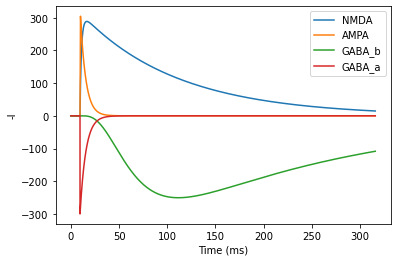

In [36]:
(I_ext, duration) = bp.inputs.constant_current([(0, 1), (35, 15), (0, 300)])

# AMPA
neu = bm.neurons.LIF(1)
ampa = AMPA(pre=neu, post=neu, conn=bp.connect.All2All(), monitors=['s'])
net_ampa = bp.Network(neu, ampa)
net_ampa.run(duration, inputs=(neu, "input", I_ext))

# NMDA
neu = bm.neurons.LIF(1)
nmda = NMDA(pre=neu, post=neu, conn=bp.connect.All2All(), monitors=['s'])
net_nmda = bp.Network(neu, nmda)
net_nmda.run(duration, inputs=(neu, "input", I_ext))

# GABA_a
neu = bm.neurons.LIF(1)
gabaa = GABAa(pre=neu, post=neu, conn=bp.connect.All2All(), monitors=['s'])
net_gabaa = bp.Network(neu, gabaa)
net_gabaa.run(duration, inputs=(neu, "input", I_ext))

# GABA_b
neu = bm.neurons.LIF(1)
gabab = GABAb(pre=neu, post=neu, conn=bp.connect.All2All(), monitors=['s'])
net_gabab = bp.Network(neu, gabab)
net_gabab.run(duration, inputs=(neu, "input", I_ext))


# visualization
ts = net_nmda.ts

plt.plot(ts, nmda.mon.s[:, 0]* 0.15 * (-65 - 0) * -50, label='NMDA')
plt.plot(ts, ampa.mon.s[:, 0]* 0.45 * (-65 - 0) * -50, label='AMPA')
plt.plot(ts, gabab.mon.s[:, 0]* (-65 + 95) * -200 * 1e+7, label='GABA_b')
plt.plot(ts, gabaa.mon.s[:, 0] * 0.4 * (-65 + 80) * -50, label='GABA_a')
plt.ylabel('-I')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()